In [ ]:
%pip install pandas

In [ ]:
%pip install numpy seaborn matplotlib scikit-learn biopython

# Load and prep data

In [5]:
## Import libraries
import pandas as pd
import numpy as np
import subprocess
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1.1 Load and Clean the Raw Data ---
print("Loading the dataset...")

data_df = pd.read_csv('apoha dataset/expanded_antibody_vibe.csv')

print(f"Initial dataset shape: {data_df.shape}")

# Create a batch column from the 'ID' column
data_df['APH_Batch'] = data_df['ID'].apply(lambda x: x.split('-')[0])
# Correct for any batch name anomalies
data_df['APH_Batch'] = data_df['APH_Batch'].apply(lambda x: x[:-1] if len(x) > 4 else x)

# Drop the now-redundant ID column
data_df = data_df.drop(columns=['ID'])

# Filter out the APH2 batch 
data_df = data_df[data_df['APH_Batch'] != 'APH2'].copy()
print(f"Shape after dropping APH2: {data_df.shape}")

# Drop any rows with missing sequences
data_df.dropna(subset=['VH', 'VL', 'VIBE1'], inplace=True)
print(f"Shape after dropping NA: {data_df.shape}")


# --- 1.2 Aggregate Replicates to Create Unique Antibody Entries ---
# Calculate the mean VIBE1 score
print("\nAggregating replicates...")
agg_funcs = {
    'VH': 'first',
    'VL': 'first',
    'VIBE1': 'mean',
    'APH_Batch': 'first'
}
unique_antibodies_df = data_df.groupby('Name').agg(agg_funcs).reset_index()

print(f"Final unique antibody dataset shape: {unique_antibodies_df.shape}")
print("Data preparation and cleaning complete.")
unique_antibodies_df.head()

Loading the dataset...
Initial dataset shape: (1182, 5)
Shape after dropping APH2: (999, 5)
Shape after dropping NA: (993, 5)

Aggregating replicates...
Final unique antibody dataset shape: (234, 5)
Data preparation and cleaning complete.


,Name,VH,VL,VIBE1,APH_Batch
0,abituzumab,QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,0.028158,APH1
1,abrilumab,QVQLVQSGAEVKKPGASVKVSCKVSGYTLSDLSIHWVRQAPGKGLE...,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...,0.031197,APH1
2,adalimumab,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...,0.026872,APH1
3,afasevikumab,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVRSYLAWYQQKPGQAPRL...,0.025069,APH3
4,alemtuzumab,QVQLQESGPGLVRPSQTLSLTCTVSGFTFTDFYMNWVRQPPGRGLE...,DIQMTQSPSSLSASVGDRVTITCKASQNIDKYLNWYQQKPGKAPKL...,0.031691,APH1


In [ ]:
unique_antibodies_df.to_csv("expanded_antibody_vibe_mean.csv", index=False)

# DeepSP

In [ ]:
import pandas as pd

# Load data file
df = pd.read_csv("expanded_antibody_vibe_mean.csv")

# Select and rename the columns for the DeepSP input
deepsp_input_df = df[['Name', 'VH', 'VL']].rename(columns={
    'Name': 'Id',
    'VH': 'Heavy_Chain',
    'VL': 'Light_Chain'
})

# Save the new DataFrame to a CSV file
deepsp_input_df.to_csv("DeepSP_input.csv", index=False)

print("Successfully created DeepSP_input.csv")
print(deepsp_input_df.head())

# ANARCI

In [ ]:
""""
seq_aligned_H.csv and seq_aligned_L.csv generated by the DeepSP model first

"""


In [ ]:
#!/usr/bin/env python3
import pandas as pd

# 1) Kyte–Doolittle hydropathy index
HYDRO = {
    'A':1.8, 'C':2.5, 'D':-3.5, 'E':-3.5, 'F':2.8,
    'G':-0.4,'H':-3.2,'I':4.5, 'K':-3.9,'L':3.8,
    'M':1.9, 'N':-3.5,'P':-1.6,'Q':-3.5,'R':-4.5,
    'S':-0.8,'T':-0.7,'V':4.2, 'W':-0.9,'Y':-1.3,
    '-':0.0    # gaps count as neutral
}

def gravy(seq):
    if not seq:
        return 0.0
    return sum(HYDRO.get(aa,0.0) for aa in seq) / len(seq)

# 2) IMGT CDR ranges (1-based inclusive)
CDR_RANGES = {
  'H': {
    'CDR1': range(27, 39),  # 27–38
    'CDR2': range(56, 66),  # 56–65
    'CDR3': range(105,118)  # 105–117
  },
  'L': {
    'CDR1': range(27, 39),
    'CDR2': range(56, 66),
    'CDR3': range(105,118)
  }
}

# 3) Load ANARCI output
H = pd.read_csv("DeepSP/seq_aligned_H.csv",  index_col="Id", dtype=str).fillna("-").astype(str)
L = pd.read_csv("DeepSP/seq_aligned_KL.csv", index_col="Id", dtype=str).fillna("-").astype(str)

rows = []
for id_ in H.index:
    # full ungapped sequences
    full_H = "".join(H.loc[id_].tolist()).replace("-","")
    full_L = "".join(L.loc[id_].tolist()).replace("-","")

    data = {
      "Id":           id_,
      "GRAVY_VH":     round(gravy(full_H),  3),
      "GRAVY_VL":     round(gravy(full_L),  3),
    }

    # each CDR by chain
    for chain, df in (("H", H), ("L", L)):
        for name, rng in CDR_RANGES[chain].items():
            cols = [str(pos) for pos in rng]
            seq = "".join(df.loc[id_, cols].tolist()).replace("-","")
            data[f"GRAVY_{chain}{name}"] = round(gravy(seq), 3)

    rows.append(data)

out = pd.DataFrame(rows)
out.to_csv("cdrs_and_gravy_from_anarci.csv", index=False)
print("cdrs_and_gravy_from_anarci.csv written")


# Merging 

In [ ]:
import pandas as pd

gravy = pd.read_csv("cdrs_and_gravy_from_anarci.csv")
deep  = pd.read_csv("DeepSP/DeepSP_descriptors.csv")


# merge on the matching column
merged = pd.merge(gravy, deep, on="Id", how="inner")
final  = pd.merge(f, merged, on="Id", how="inner")

final.to_csv("final_all_descriptors.csv", index=False)
print("Merged file written")


In [ ]:
# Loading Clinical Status file
print("\nLoading clinical status information from 'antibody_jain_vibe_score.csv'...")
try:
    full_data_with_status = pd.read_csv('apoha dataset/antibody_jain_vibe_score.csv')
    u =pd.read_csv('final_all_descriptors.csv')
    status_info_df = full_data_with_status[['Name', 'Status']].copy()

    # Merge the status information into our main dataframe.
    final_df = pd.merge(
        u,
        status_info_df,
        on='Name',
        how='left'
    )
    
    # Handle any antibodies that might not have a status listed.
    final_df['Status'].fillna('Unknown', inplace=True)

    print("Clinical status merged successfully.")

except FileNotFoundError:
    print("Warning: 'antibody_jain_vibe_score.csv' not found. Cannot add clinical status.")
    # If the file isn't found, create a placeholder 'Status' column to allow the script to continue.
    final_df = unique_antibodies_df.copy()
    final_df['Status'] = 'Unknown'

print("Clinical status processing complete")
final_df.head()

# EDA

In [ ]:
df = pd.read_csv("final_all_descriptors.csv")
df["high_risk_flag"] = df["VIBE1"] >= 0.26
print("Any high‐risk at ≥0.26? ", df["high_risk_flag"].any())  


In [ ]:
print(df["Status"].value_counts(dropna=False))



## Approved vs Terminated -> stats

In [ ]:
import pandas as pd

# ─── 1) Load ────────────────────────────────────────────────────────────
#df = pd.read_csv("final_all_descriptors.csv")

# ─── 2) Select numeric descriptor columns (plus VIBE1) ─────────────────
exclude = ["Name", "Status", "VH", "VL"]        
numeric_cols = [
    c for c in df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df[c])
]

# ─── 3) Build a per-status summary for every descriptor ────────────────
summaries = []
for status in ["Approved", "Terminated"]:
    stats = (
        df[df["Status"] == status][numeric_cols]
        .agg(["min", "max", "mean", "median", "std"])   
        .T                                              # rows → descriptors
    )
    # Rename columns to encode the status
    stats.columns = [f"{status}_{stat}" for stat in stats.columns]
    summaries.append(stats)

# ─── 4) Concatenate side-by-side ───────────────────────────────────────
descriptor_summary = pd.concat(summaries, axis=1)

# ─── 5) Save or inspect ────────────────────────────────────────────────
descriptor_summary.to_csv("descriptor_summary_by_status.csv", float_format="%.4g")

print(descriptor_summary.head().round(3))


               Approved_min  Approved_max  Approved_mean  Approved_median  \
VIBE1                 0.022         0.120          0.033            0.029   
SAP_pos_CDRH1        -2.526         1.513         -0.569           -0.628   
SAP_pos_CDRH2         0.813        15.918          6.139            5.605   
SAP_pos_CDRH3         3.682        16.012          8.131            7.613   
SAP_pos_CDRL1        -1.167         4.951          2.209            2.599   

               Approved_std  Terminated_min  Terminated_max  Terminated_mean  \
VIBE1                 0.017           0.022           0.210            0.046   
SAP_pos_CDRH1         0.865          -3.378           3.900           -0.505   
SAP_pos_CDRH2         3.006           0.309          14.920            5.437   
SAP_pos_CDRH3         2.567           3.216          23.037            7.483   
SAP_pos_CDRL1         1.488          -1.381           8.271            2.077   

               Terminated_median  Terminated_std  
VIBE1

## Summary Stats

In [ ]:
final_df = pd.read_csv("final_all_descriptors.csv")

In [ ]:
deep_cols = [col for col in final_df.columns if col.startswith("GRAVY") or col.startswith("SAPT") or col.startswith("SCM")]

In [ ]:
for col in deep_cols:
    lo, hi, mu, sigma, med = (
        final_df[col].min(),
        final_df[col].max(),
        final_df[col].mean(),
        final_df[col].std(),
        final_df[col].median(),
    )
    print(
        f"  {col:20s}"
        f"  min={lo:.3f}, max={hi:.3f},"
        f" mean={mu:.3f}, std={sigma:.3f}, median={med:.3f}"
    )


## Descriptor distribution

In [ ]:

# Distributions of GRAVY, DeepSP, and VIBE1

# numeric cols to plot
plot_cols = ["GRAVY_VH","GRAVY_VL","VIBE1", 'GRAVY_HCDR1', 'GRAVY_HCDR2',
       'GRAVY_HCDR3', 'GRAVY_LCDR1', 'GRAVY_LCDR2', 'GRAVY_LCDR3'] + deep_cols

for col in plot_cols:
    plt.figure(figsize=(4,3))
    sns.histplot(final_df[col].dropna(), stat="density", bins=30, kde=False)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


## Distribution according to status

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


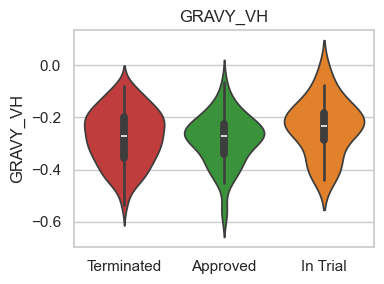

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


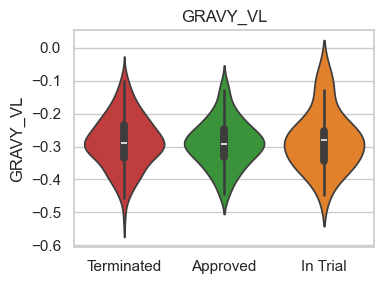

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


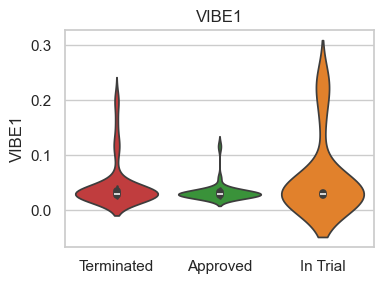

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


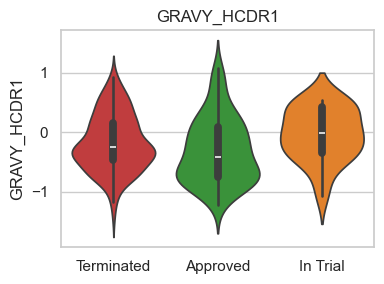

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


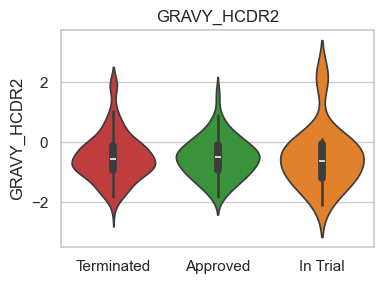

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


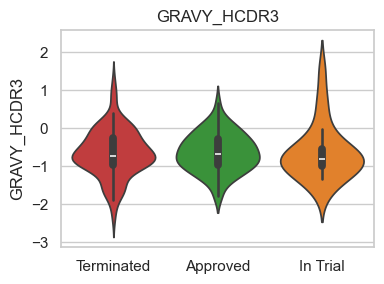

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


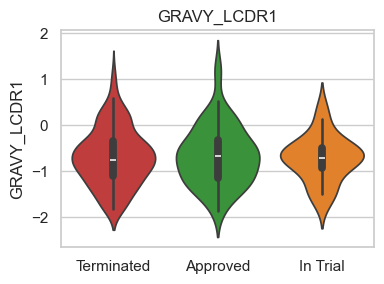

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


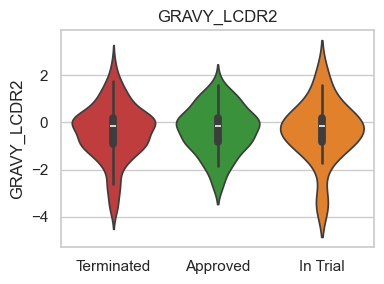

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


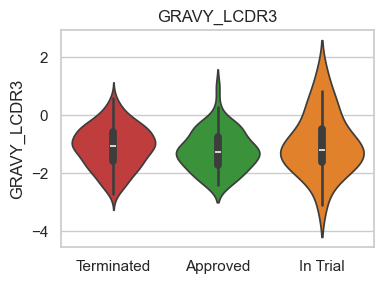

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


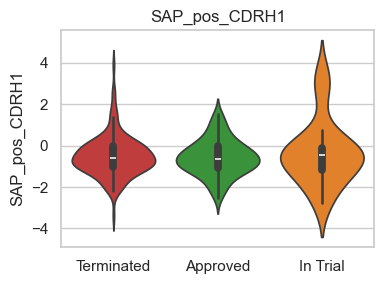

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


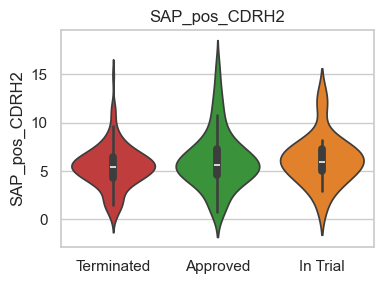

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


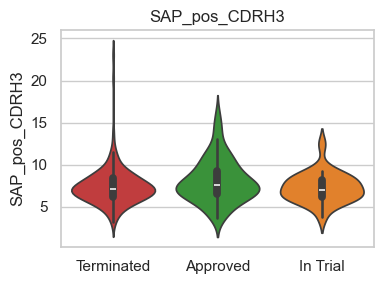

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


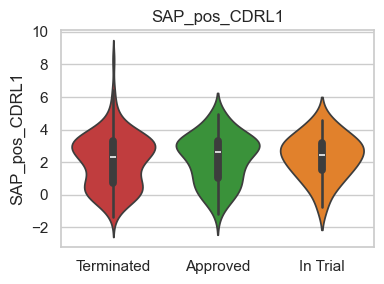

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


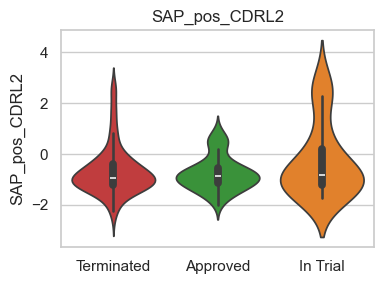

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


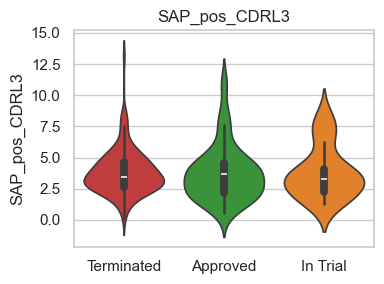

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


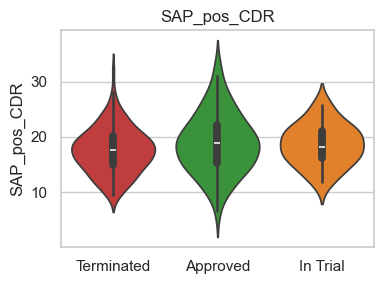

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


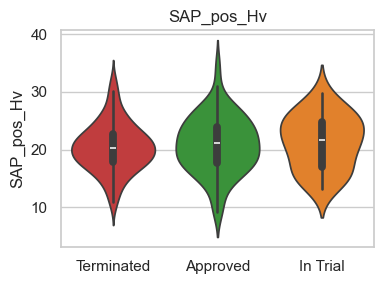

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


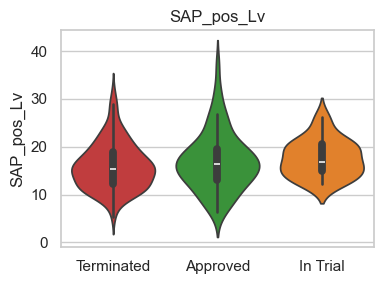

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


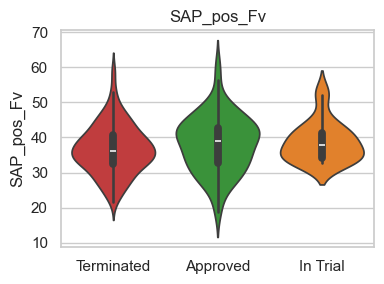

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


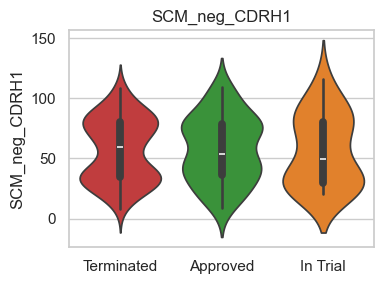

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


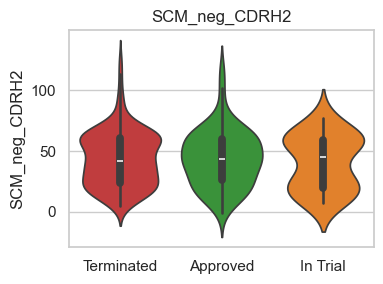

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


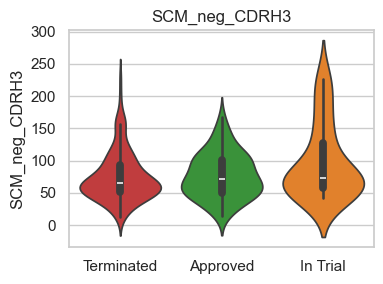

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


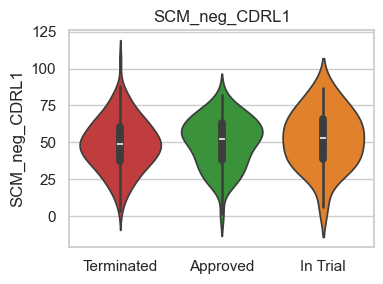

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


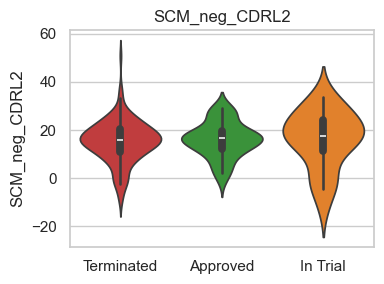

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


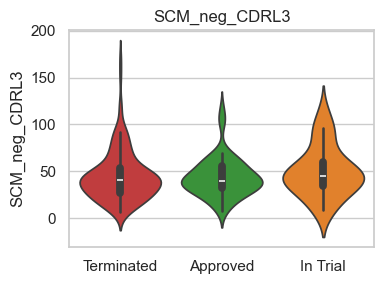

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


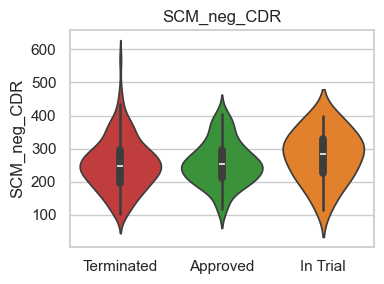

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


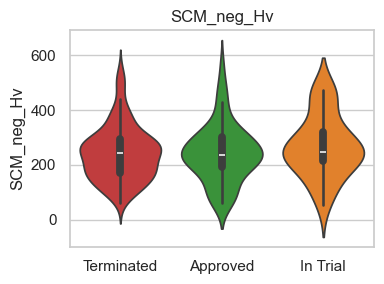

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


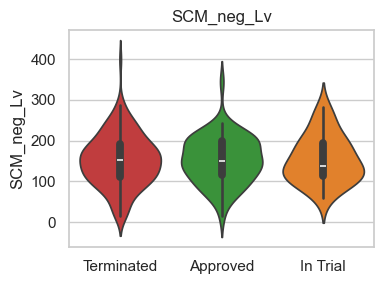

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


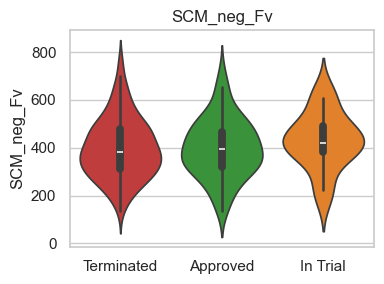

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


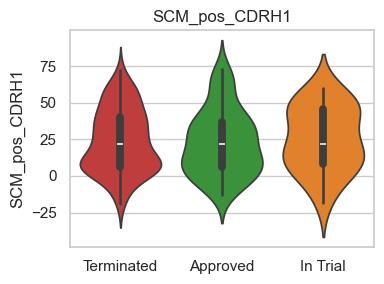

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


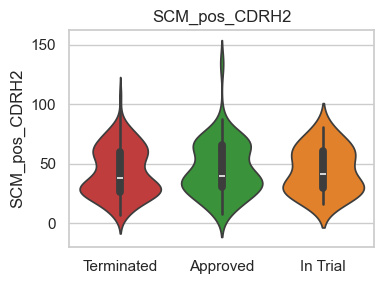

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


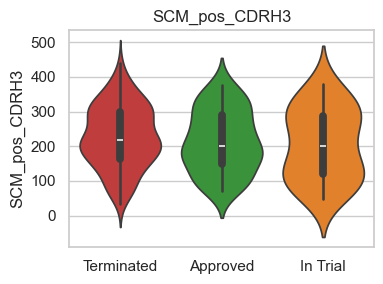

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


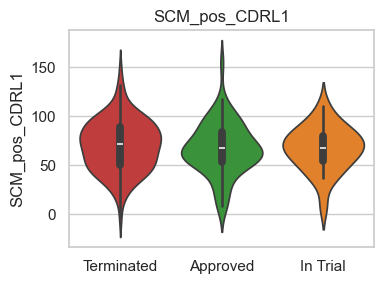

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


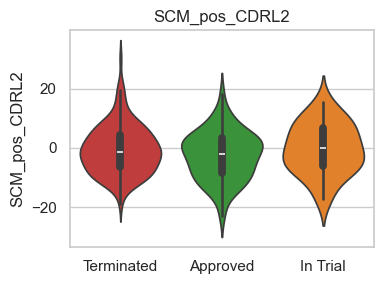

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


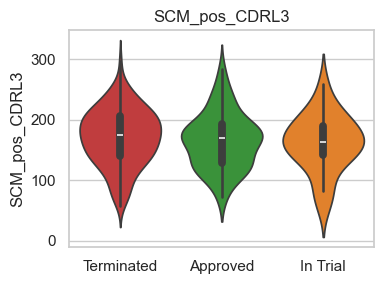

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


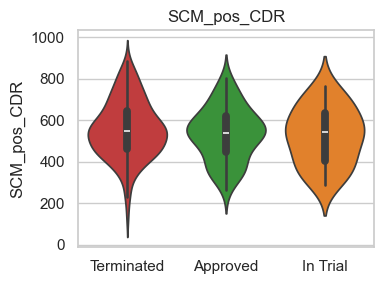

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


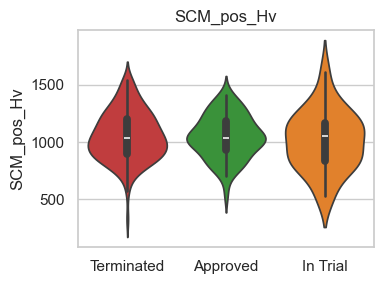

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


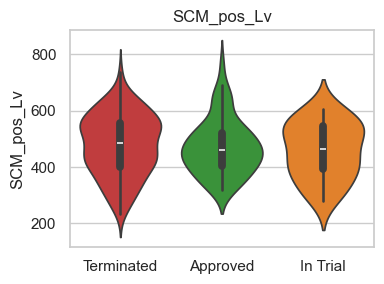

/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/c0/df58tmfj3x5dfml27z8p85_m0000gn/T/ipykernel_93448/2498943358.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


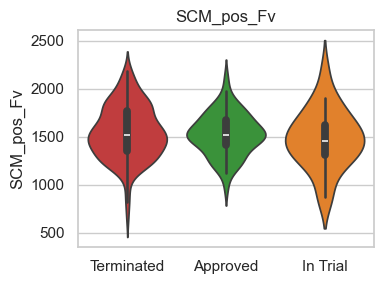

In [ ]:
# define your palette as before
status_palette = {
    "Approved":   "#2ca02c",
    "Terminated": "#d62728",
    "In Trial":   "#ff7f0e"
}
for col in plot_cols:
    plt.figure(figsize=(4,3))
    sns.violinplot(
        data= final_df,
        x="Status",
        y=col,
        palette=status_palette,
        inner="box",
        scale = 'width',  # very light smoothing
    )
    plt.title(col, fontsize=12)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

## Pearson and Spearman correlation 

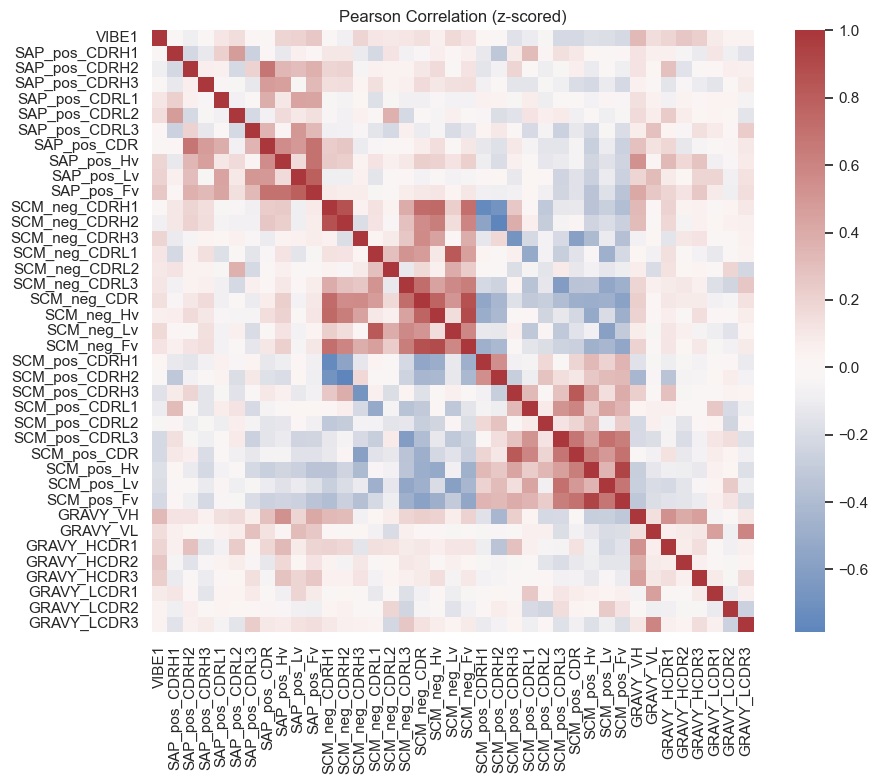

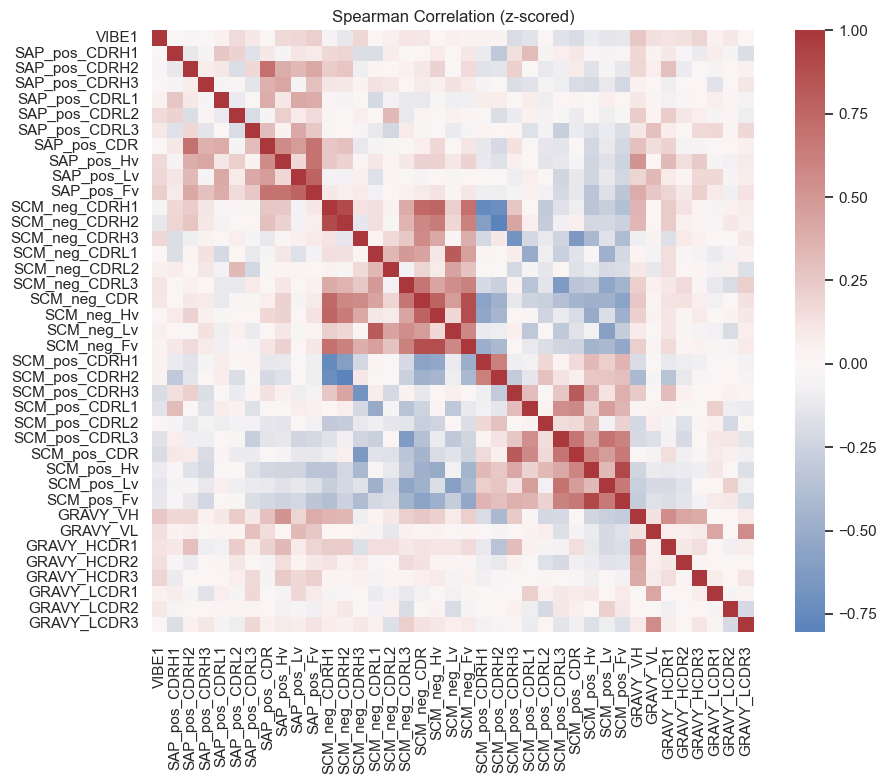

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1) Load
#df = pd.read_csv("final_all_descriptors.csv")

# 2) Identify numeric descriptor columns
exclude = ["Name"]
numeric_cols = [c for c in df.columns if c not in exclude and np.issubdtype(df[c].dtype, np.number)]

# 3) Scale with z‐score
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numeric_cols].fillna(0))  # fillna=0 or dropna depending on your preference
scaled_df = pd.DataFrame(scaled_array, columns=numeric_cols)

# 4) Compute correlation matrices on the scaled data
pearson_corr = scaled_df.corr(method="pearson")
spearman_corr = scaled_df.corr(method="spearman")

# 5) Plot 
plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr, cmap="vlag", center=0, square=True)
plt.title("Pearson Correlation (z-scored)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, cmap="vlag", center=0, square=True)
plt.title("Spearman Correlation (z-scored)")
plt.tight_layout()
plt.show()

# 6) Save to CSV 
pearson_corr.to_csv("pearson_scaled_descriptors.csv")
spearman_corr.to_csv("spearman_scaled_descriptors.csv")




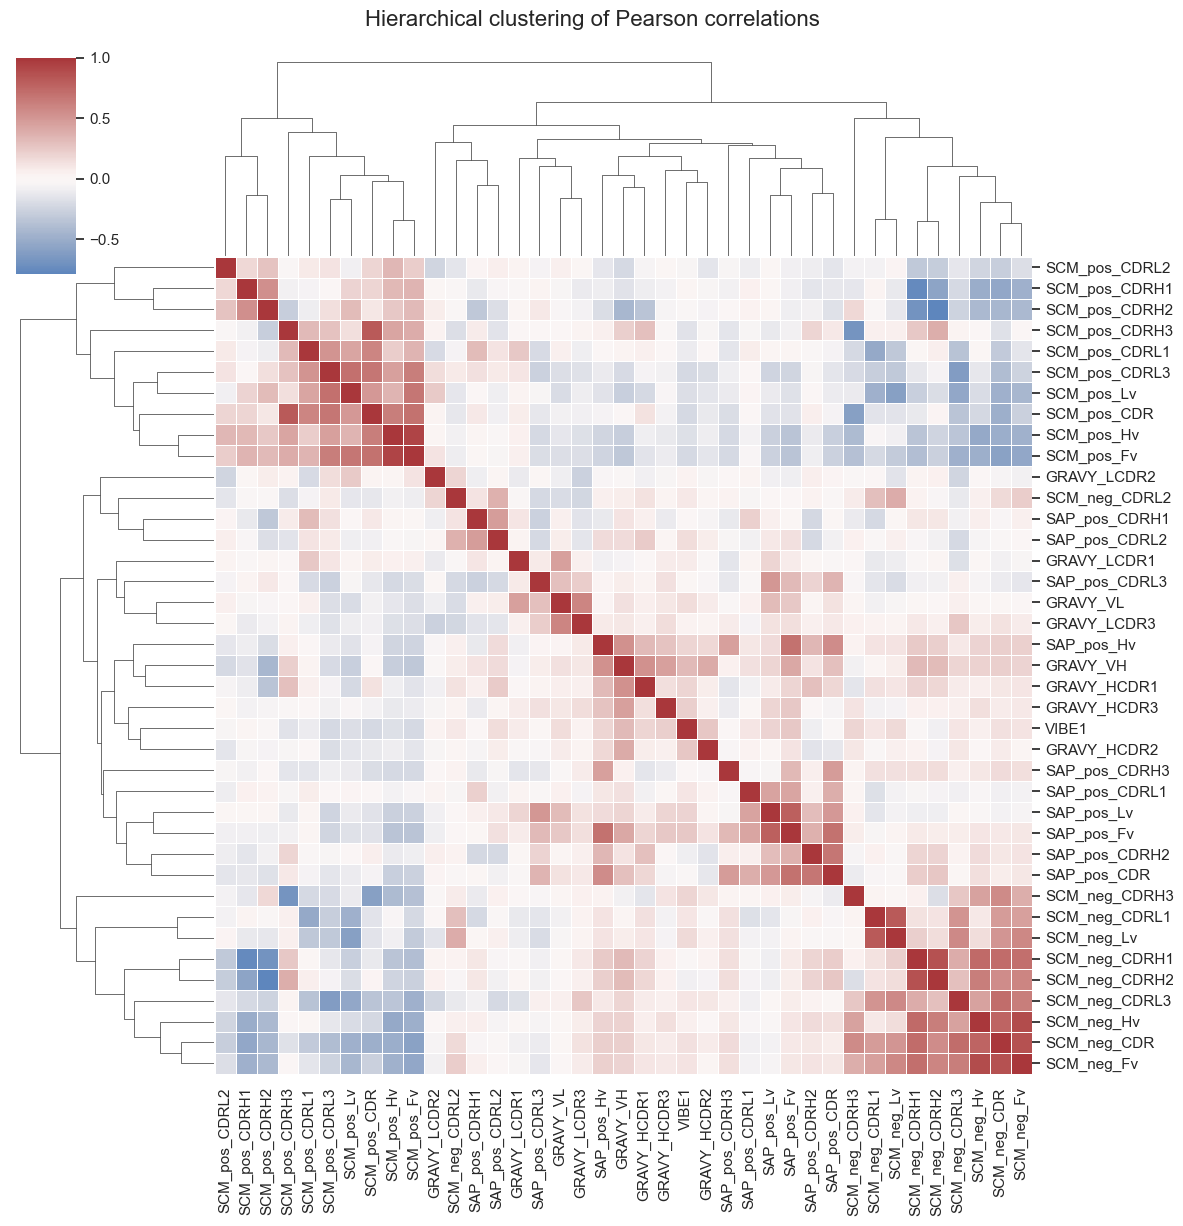

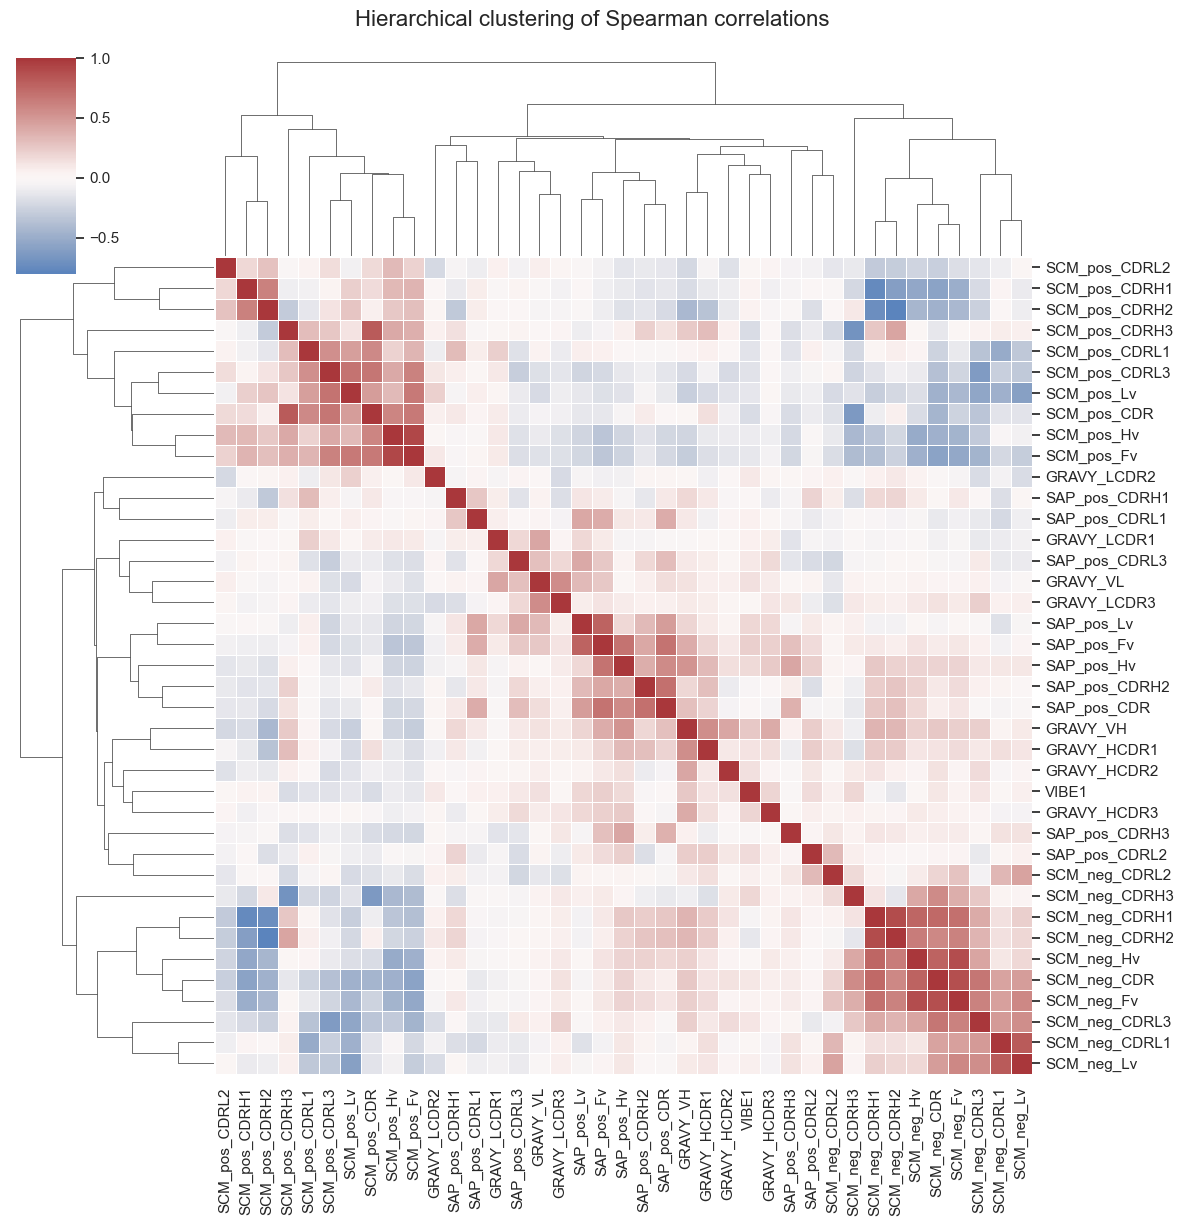

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# 1) Pearson clustermap 
sns.clustermap(
    pearson_corr,
    method="average",       
    metric="euclidean",     
    cmap="vlag",            
    center=0,              
    linewidths=0.5,
    figsize=(12,12)
)
plt.suptitle("Hierarchical clustering of Pearson correlations", y=1.02, fontsize=16)
plt.show()

# 2) Spearman clustermap 
sns.clustermap(
    spearman_corr,
    method="average",
    metric="euclidean",
    cmap="vlag",
    center=0,
    linewidths=0.5,
    figsize=(12,12)
)
plt.suptitle("Hierarchical clustering of Spearman correlations", y=1.02, fontsize=16)
plt.show()


## Mann Whitney u test

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests   # pip install statsmodels

# 1) Load & choose numeric columns 
#df = pd.read_csv("final_all_descriptors.csv")

exclude = ["Name", "Status", "VH", "VL"]          
numeric_cols = [
    c for c in df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df[c])
]                                                

# 2) Split into the two status groups 
approved   = df[df["Status"] == "Approved"]
terminated = df[df["Status"] == "Terminated"]

# 3) Mann-Whitney-U 
records = []

for col in numeric_cols:
    a_vals = approved[col].dropna()
    t_vals = terminated[col].dropna()

    # two-sided Mann–Whitney U test
    stat, p = mannwhitneyu(a_vals, t_vals, alternative="two-sided")

    records.append({
        "Descriptor": col,
        "Δ Mean (Approved − Terminated)": a_vals.mean() - t_vals.mean(),
        "Δ SD (Approved − Terminated)":   a_vals.std(ddof=1) - t_vals.std(ddof=1),
        "p-value": p
    })

results = pd.DataFrame(records).sort_values("p-value")

# 4) FDR correction for multiple tests
reject, p_adj, *_ = multipletests(results["p-value"], method="fdr_bh")
results["FDR-adj p"] = p_adj

# 5) Save &/or display 
results.to_csv("mannwhitney_approved_vs_terminated.csv", index=False, float_format="%.4g")
print(results.head(15).to_string(index=False))


   Descriptor  Δ Mean (Approved − Terminated)  Δ SD (Approved − Terminated)  p-value  FDR-adj p
  GRAVY_HCDR1                       -0.129780                      0.071083 0.035882   0.920133
SAP_pos_CDRH3                        0.648269                      0.197305 0.050556   0.920133
  SAP_pos_CDR                        1.328143                      1.255252 0.092926   0.920133
   SAP_pos_Fv                        1.549806                      0.998017 0.120238   0.920133
  GRAVY_LCDR3                       -0.135603                     -0.027036 0.126553   0.920133
        VIBE1                       -0.013218                     -0.026413 0.162963   0.920133
SAP_pos_CDRH2                        0.701703                      0.782120 0.221818   0.920133
SCM_pos_CDRL2                       -1.960218                     -0.046060 0.227494   0.920133
SCM_pos_CDRL3                       -5.515975                     -0.890007 0.283261   0.920133
SCM_pos_CDRH3                      -13.3

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# 1) Load data and pick numeric columns 
#df = pd.read_csv("final_all_descriptors.csv")

exclude = ["Name", "Status", "VH", "VL"]          
numeric_cols = [
    c for c in df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df[c])
]

# 2) Split by VIBE threshold 
thresh = 0.086
high_df = df[df["VIBE1"] >  thresh]
low_df  = df[df["VIBE1"] <= thresh]

#3) Mann-Whitney U test per descriptor
records = []
for col in numeric_cols:
    high_vals = high_df[col].dropna()
    low_vals  = low_df[col].dropna()

    stat, p = mannwhitneyu(high_vals, low_vals, alternative="two-sided")

    records.append({
        "Descriptor": col,
        "Δ Mean (High − Low)": high_vals.mean() - low_vals.mean(),
        "Δ SD (High − Low)":   high_vals.std(ddof=1) - low_vals.std(ddof=1),
        "p-value": p
    })

results = pd.DataFrame(records).sort_values("p-value")

# 4) FDR correction 
results["FDR-adj p"] = multipletests(results["p-value"],
                                     method="fdr_bh")[1]

# 5) Save & display 
results.to_csv("mannwhitney_high_low_vibe.csv",
               index=False, float_format="%.4g")

print(results.head(15).to_string(index=False))


   Descriptor  Δ Mean (High − Low)  Δ SD (High − Low)      p-value    FDR-adj p
        VIBE1             0.125962           0.037114 3.199104e-16 1.247651e-14
     GRAVY_VH             0.090741          -0.014700 6.007103e-05 1.171385e-03
   SAP_pos_Fv             5.001162           0.299236 2.476965e-03 3.033270e-02
  GRAVY_HCDR3             0.404411           0.002589 3.830975e-03 3.033270e-02
SCM_pos_CDRL3           -30.223999           1.427847 4.531610e-03 3.033270e-02
   SAP_pos_Lv             3.284645           0.586549 4.666569e-03 3.033270e-02
   SCM_neg_Lv            32.368063          -8.123827 1.017810e-02 4.824836e-02
  GRAVY_HCDR1             0.253174          -0.058338 1.020690e-02 4.824836e-02
   SCM_pos_Fv          -145.489205          11.228980 1.113424e-02 4.824836e-02
  SCM_pos_CDR           -78.059835           2.351674 1.388198e-02 5.413972e-02
   SCM_pos_Lv           -56.227471           8.722065 2.211639e-02 7.841264e-02
     GRAVY_VL             0.036755      

## Elastic net regression model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    roc_curve, auc, confusion_matrix
)


# Load data 

#df = pd.read_csv("final_all_descriptors.csv")

exclude = ["Name", "Status", "VH", "VL"]
numeric_cols = [
    c for c in df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df[c])
]


# Elastic-net REGRESSION  (target = VIBE1)

X_reg = df[numeric_cols].drop(columns=["VIBE1"])
y_reg = df["VIBE1"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("enet",  ElasticNetCV(
                 l1_ratio=[0.1,0.3,0.5,0.7,0.9,1.0],
                 alphas=np.logspace(-3,1,20),
                 cv=5,
                 max_iter=5000,
                 random_state=42))
])

reg_pipe.fit(Xr_train, yr_train)
yr_pred = reg_pipe.predict(Xr_test)

print(f"\nVIBE1  –  RMSE: {np.sqrt(mean_squared_error(yr_test, yr_pred)):.4f}   "
      f"R²: {r2_score(yr_test, yr_pred):.3f}")

